In [4]:
# Install third party / library
!pip install torchsummary

In [5]:
# Import library
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


## Data Preparation,Preprocessing


In [7]:
# Define data directory for train and validation data
data_dir = "/content/drive/MyDrive/TA-GROUP11/DATASET"
train_dir = data_dir + "/DATA_TRAINING"
valid_dir = data_dir + "/DATA_VALID"
corn_diseases = os.listdir(train_dir)
corn_diseases

['Training_GLS', 'Training_HL', 'Training_Rust', 'Training_NLB']

In [8]:
# Get all disesase name from Corn
corn_diseases.sort()
for path in corn_diseases:
    print(path + " => " + str(len(os.listdir(train_dir +'/'+ path))))

Training_GLS => 1652
Training_HL => 1859
Training_NLB => 1908
Training_Rust => 1917


In [9]:
# Let's Calculate total files from disease corn
total_files = 0
for path in corn_diseases:
    total_files += len(os.listdir(train_dir +'/'+ path))
print("Total of Disease Classes : %d"%len(corn_diseases))
print("Total all files : %d"%total_files)

Total of Disease Classes : 4
Total all files : 7336


In [10]:
# Calculate number of disease dari corn_plant datasets
NumberOfDiseases = 0
for plant in corn_diseases:
    if plant != 'Training_HL':
        NumberOfDiseases += 1

In [11]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 3


In [12]:
# Number of images for each disease
nums = {}
for disease in corn_diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Training_GLS,1652
Training_HL,1859
Training_NLB,1908
Training_Rust,1917


In [13]:
print(nums.values())

dict_values([1652, 1859, 1908, 1917])


### Data Visualization (membantu memahami data kita)

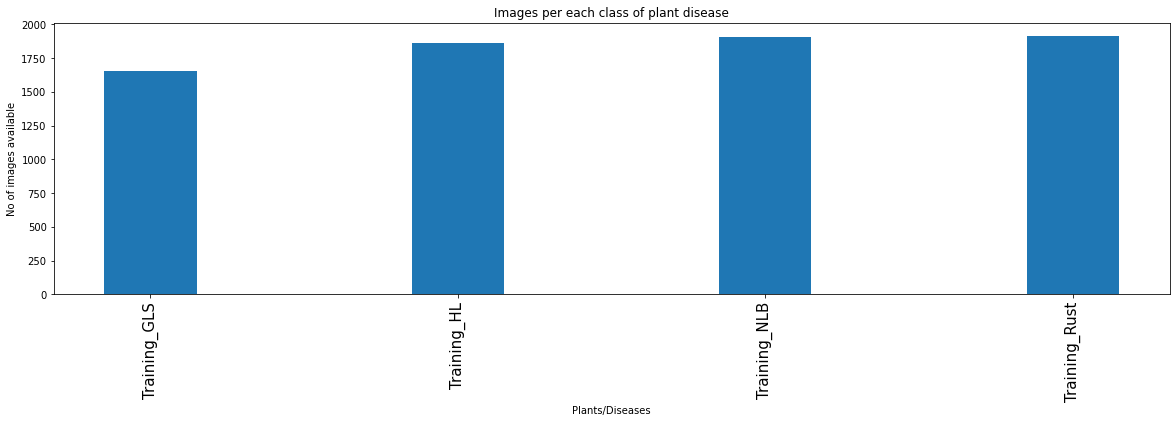

In [14]:
# plotting number of images available for each disease
def show_plot(data):
    index = [n for n in range(len(data))]
    plt.figure(figsize=(20, 5))
    plt.bar(index, [n for n in nums.values()], width=0.3)
    plt.xlabel('Plants/Diseases', fontsize=10)
    plt.ylabel('No of images available', fontsize=10)
    plt.xticks(index, data, fontsize=15, rotation=90)
    plt.title('Images per each class of plant disease')
show_plot(corn_diseases)

Ya udah bisalah, setiap kelas size of data nya udah hampir sama, mungkin nanti bakal disamakan lagi biar performance lebih baik

In [15]:
# Helper, check available image for training data
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 7336 images for training


### Data Preparation for training 

In [16]:
# datasets for validation and training
# https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
# root fill using root dir, untuk hal ini train_dir dan valid_dir
# tranform using ToTensor()
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [17]:
# check  type
#Helper doang
print([type(train),type(valid)])

[<class 'torchvision.datasets.folder.ImageFolder'>, <class 'torchvision.datasets.folder.ImageFolder'>]


#### Preprocessing mode 

In [18]:
img, label = train[0]
print(img.shape, label)
# We can see the shape (3, 256 256) of the image. 3 is the number of channels (RGB) and 256 x 256 
# is the width and height of the image

torch.Size([3, 256, 256]) 0


In [19]:
# total number of classes in train set
# Helper
len(train.classes)

4

In [20]:
# for checking some images from training dataset
# Helper funciton
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

#### Coba untuk menampilkan data image

Label :Training_GLS(0)


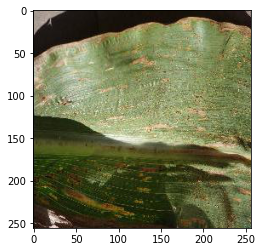

In [21]:
show_image(*train[0])

Label :Training_GLS(0)


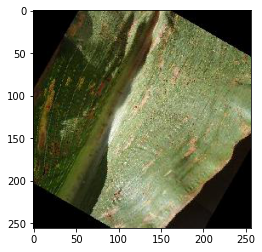

In [22]:
show_image(*train[1])

Label :Training_GLS(0)


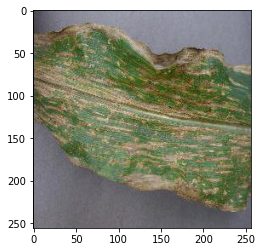

In [23]:
show_image(*train[len(corn_diseases)-1])

Label :Training_HL(1)


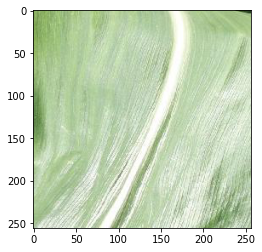

In [24]:
show_image(*train[2000])

In [25]:
# Setting the seed value
# https://pytorch.org/docs/stable/generated/torch.manual_seed.html
#  generate randoom_number
# rentang : [-0x8000_0000_0000_0000, 0xffff_ffff_ffff_ffff]
random_seed = 7
torch.manual_seed(random_seed)

In [26]:
# setting the batch size
batch_size = 32
"""
batch_size is the total number of images given as input at once in forward propagation of the CNN. 
Basically, batch size defines the number of samples that will be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. 
The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. 
Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. 
We can keep doing this procedure until we have propagated all samples through of the network.
"""

"\nbatch_size is the total number of images given as input at once in forward propagation of the CNN. \nBasically, batch size defines the number of samples that will be propagated through the network.\n\nFor instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. \nThe algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. \nNext, it takes the second 100 samples (from 101st to 200th) and trains the network again. \nWe can keep doing this procedure until we have propagated all samples through of the network.\n"

In [27]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [28]:
# helper function to show a batch of training instances
def show_batch(data,nrow = 8):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow).permute(1, 2, 0))
        break

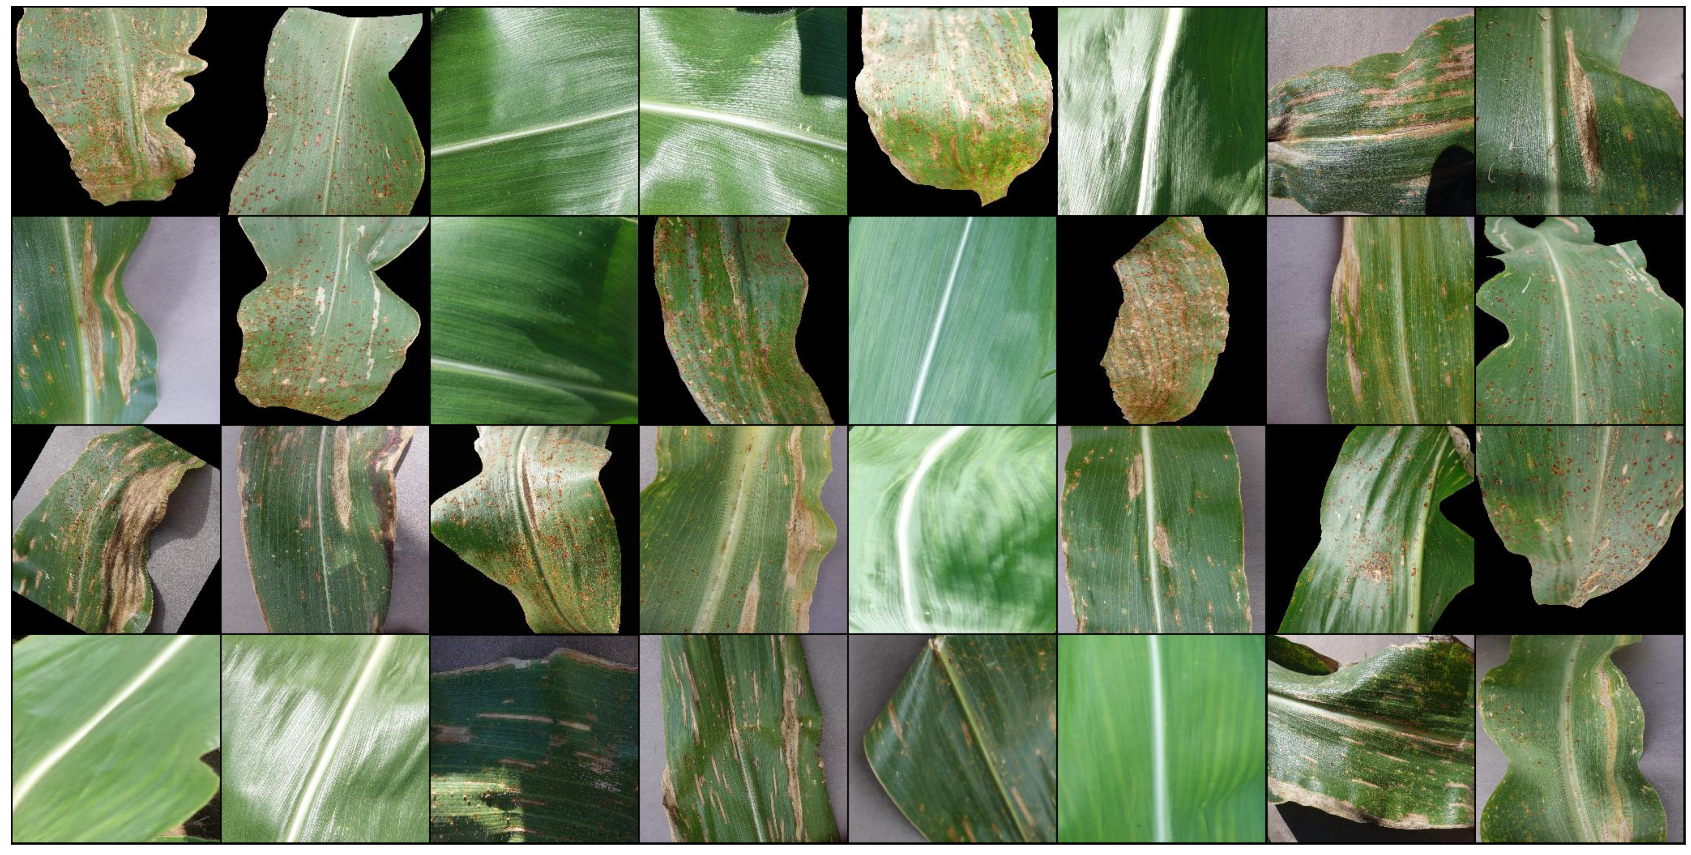

In [ ]:
# Images for first batch of training
show_batch(train_dl,8) 

## Modelling :"""

Harap menggunakan GPU :"
Karena memerlukan komputasi yang besar, GPU dapat melakukan processing secara async untuk banyak thread

Namun disini menggunakan CPU karena , yang GPU di file berbeda :)

In [ ]:
# for moving data into GPU (if available)
#  From internet ot check, device kita menggunakan GPU atau CPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')


### Building Model Architecture....

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [ ]:
# Architecture for training
#  Final Architecture
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [ ]:
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cpu(), (INPUT_SHAPE)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [ ]:
# for training
import math
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    step_per_epoch = math.floor(len(train_loader)/epochs)
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [ ]:
%%time
history = [evaluate(model, train_dl)]
history

In [ ]:
epochs = 7
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00482, train_loss: 0.2244, val_loss: 3.2252, val_acc: 0.5359
Epoch [1], last_lr: 0.00995, train_loss: 0.2879, val_loss: 0.1299, val_acc: 0.9483
Epoch [2], last_lr: 0.00919, train_loss: 0.1792, val_loss: 0.5201, val_acc: 0.8172


### Plotting && Visualize

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
# Validation Accurasi tiap epochs
plot_accuracies(history)

In [ ]:
# Learning Rate overtime
plot_lrs(history)

### Testing :""

In [ ]:
test_dir = "/content/drive/MyDrive/TA-GROUP11/DATASET"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
test_images = sorted(os.listdir(test_dir + '/DATA_TESTING')) # since images in test folder are in alphabetical order
test_images

In [ ]:
# Helper function
# Predict Image
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [ ]:
print(type(test))
print("Len of Test %s"%len(test))

In [ ]:
# predicting first image
ti = 18
img, label = test[ti]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[ti], ', Predicted:', predict_image(img, model))

In [ ]:
# getting all predictions (actual label vs predicted)
test_images.sort()
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Saving Model

In [ ]:
# saving to the kaggle working directory
PATH = '/content/drive/MyDrive/TA-GROUP11/DATASET/plant-disease-model-cpu.pth'  
torch.save(model.state_dict(), PATH)

In [ ]:
# saving the entire model to working directory
PATH = '/content/drive/MyDrive/TA-GROUP11/DATASET/plant-disease-model-complete-cpu.pth'
torch.save(model, PATH)

### Confusion Matrix :D

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
def confusion_matrix(preds, labels, conf_matrix, title='Confusion matrix', cmap=plt.cm.Blues):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1

    #print(conf_matrix)
    #plt.imshow(conf_matrix)
    TP = conf_matrix.diag()
    for c in range(n_classes):
        idx = torch.ones(n_classes).byte()
        idx[c] = 0
        TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
        FP = conf_matrix[c, idx].sum()
        FN = conf_matrix[idx, c].sum()

        Recall = (TP[c] / (TP[c]+FN))
        precision = (TP[c] / (TP[c]+FP))
        f1 = (2 * ((precision * Recall)/(precision + Recall)))

        #print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(c, TP[c], TN, FP, FN))
        #print('Sensitivity = {}'.format(sensitivity))
        #print('Specificity = {}'.format(specificity))
            
    return conf_matrix

In [ ]:
# n_classes = len(test.classes)
# n_classes
# confusion_matr = torch.zeros(n_classes, n_classes)
# conf_matrix = confusion_matrix(output, labels, confusion_matr)

In [ ]:
# saving to the kaggle working directory
PATH = './plant-disease-model.pth'  
torch.save(model.state_dict(), PATH)

In [ ]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)